Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Alexander Leitner"
COLLABORATORS = "01525882"

---

# DOPP 2019W Exercise 2

### Before you get started, please read the instructions in this notebook carefully.

## Preliminaries

- Please use only Python **version 3** (3.6+ recommended). It is recommended to install Anaconda or Miniconda. 

- This notebook will be scored using [nbgrader][https://nbgrader.readthedocs.io/en/stable/user_guide/highlights.html]. 
- Please use the code stubs provided, do not rename any functions, and add and modify your code only at the provided markers. 
- Check and make sure that your submission executes without any errors before submitting it. Submissions that don't execute will not be accepted.


The submission deadline is **08.01.2019 23:55.**

ections marked with `# YOUR CODE HERE` must be used to implement the functionality.
Cells containing `YOUR ANSWER HERE` must be used to fill in textual answers.

In [2]:
# Note: The only imports allowed are those contained in Python's standard library, pandas, numpy, scipy and matplotlib
import numpy as np
import pandas as pd

#add imports as needed
#import sklearn...
import glob
import matplotlib.pyplot as plt
from scipy import stats
import logging

from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Goal

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually alayse data,
 * use `scikit-learn` to build prediction models.


The goal of this exercise is to model the relationship between weather observations and the prevalence of new influenza infections.

To investigate a potential relationship, we will use two datasets:
 * daily weather observation data in Vienna (2012-2018)
 * weekly reports on [new influenza infections](https://www.data.gv.at/katalog/dataset/grippemeldedienst-stadt-wien) in Vienna (2009-2018).

**IMPORTANT:** he weather data set differs from the one used in Exercise 1. Make sure you use the correct data. The data to be used can be found in the subdirectory named `data`. 

To complete this exercise, you will have to:
* prepare the data, which (at a minimum) involves the following:
    - handling missing values,
    - handling outliers
    - temporal alignment (i.e. convert daily data to weekly data using appropriate aggregation functions),
* analyse the data:
    - compare descriptive statistics,
    - visually investigate the raw data to gain an understanding of the data, identify patterns, outliers etc.,
    - look at the relationship between the variables of interest,
* model the relationship:
    - fit a model that predicts new infections from weather observation data.

## Task 1: Load Data

Total number of points for completing this task: **10**

### Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) data sets from the csv files in `data` into a single `pd.DataFrame` and return it. 

- from the `date` column create `year`, `month`, `week`, `day` columns, where `week` contains the week number of the date. Use Pandas built-in datetime handling features.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `week` - `day` (make sure to label them accordingly)
- make sure that all columns are appropriately typed
- make sure that you load all the data (2012-2018)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Your resulting data frame should look as follows:

![Weather data frame example](weather_data_dataframe_sample.png)

In [3]:
def load_weather_data():
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Add a week column and a hierarchical index (year, month, week, day)
    
    Returns
    --------
    weather_data: data frame containing the weather data
    """
    ### BEGIN SOLUTION
    input_files = []
    for year in range(2012,2019):
        input_files.append(f"data/weather/{year}-ZAMG_Jahrbuch.csv")  
    
    data = pd.DataFrame()
    data_list = []
    for input_file in input_files:
        df = pd.read_csv(input_file,  sep=';', header = 0)
        data_list.append(df)
        

    data = pd.concat(data_list)

    data['hum_dailyMean'] = (data['hum_7h']+data['hum_14h']+data['hum_19h'])/3
    # create year, month, day, week columns
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['week'] = data['date'].dt.week
   
    data.sort_values(['year', 'month','week', 'day'], ascending = [True, True, True, True], inplace = True)
    
    data["year"] = pd.to_numeric(data["year"])
    data["week"] = pd.to_numeric(data["week"])
    
    data.set_index(['year', 'month', 'week', 'day'], inplace = True)
    data.index.set_names(['year','month','week', 'day'], inplace = True)
    
    return data
    ### END SOLUTION
    
data_weather = load_weather_data()
data_weather



Unnamed: 0       date  skyCover_7h  skyCover_14h  \
year month week day                                                     
2012 1     1    2            31 2012-01-02            0             7   
                3            60 2012-01-03           10             9   
                4            91 2012-01-04            9             9   
                5           121 2012-01-05            4             2   
                6           152 2012-01-06            5            10   
...                         ...        ...          ...           ...   
2018 12    52   26          359 2018-12-26            9             1   
                27          360 2018-12-27           10             9   
                28          361 2018-12-28            9             3   
                29          362 2018-12-29            9            10   
                30          363 2018-12-30            8            10   

                     skyCover_19h  temp_7h  temp_14h  temp_19h  \
year month week day                                              
2012 1     1    2               0    -10.1      -4.1      -9.0   
                3               8     10.0      14.3      11.6   
                4               3      2.7       7.5      40.0   
                5               1     18.6      29.7      25.6   
                6               6     16.8      16.7      17.4   
...                           ...      ...       ...       ...   
2018 12    52   26              9      2.9       6.1       4.0   
                27              2      4.9       9.3       5.5   
                28              1      6.3       8.8       4.9   
                29              9      2.9       2.9       2.6   
                30             10      2.9       3.9       5.8   

                     temp_dailyMean  temp_dailyMax  temp_dailyMin  hum_7h  \
year month week day                                                         
2012 1     1    2              -7.1           -3.6          -10.6    87.0   
                3              11.4           14.6            8.2    89.0   
                4               5.4            9.2            1.6    71.0   
                5              21.8           30.3           13.2    67.0   
                6              17.5           20.2           14.7    87.0   
...                             ...            ...            ...     ...   
2018 12    52   26              4.7            6.5            2.8    68.0   
                27              6.6            9.3            3.9    76.0   
                28              6.3            9.0            3.6    56.0   
                29              4.3            6.5            2.0    86.0   
                30              4.2            5.9            2.4    84.0   

                     hum_14h  hum_19h  windBeauf_7h  windBeauf_14h  \
year month week day                                                  
2012 1     1    2       58.0     63.0             2              2   
                3       62.0     77.0             2              1   
                4       42.0     49.0             4              3   
                5       37.0     41.0             1              4   
                6       78.0     62.0             3              3   
...                      ...      ...           ...            ...   
2018 12    52   26      58.0     66.0             3              3   
                27      64.0     76.0             3              2   
                28      53.0     67.0             2              4   
                29      73.0     71.0             3              5   
                30      91.0     75.0             5              4   

                     windBeauf_19h  precip  hum_dailyMean  
year month week day                                        
2012 1     1    2                2       0      69.333333  
                3                1       0      76.000000  
                4                2  Spuren      54.000000  

### Influenza infections

Load and prepare the second data set (`influenza.csv`), which contains the number of new influenza infections on a weekly basis, as follows:

- get rid of all columns except `Neuerkrankungen pro Woche`, `Jahr`, and `Kalenderwoche`
- rename `Neuerkrankungen pro Woche` to `weekly_infections`
- create a `MultiIndex` from the `Jahr` (→ `year`) and `Kalenderwoche` (→ `week`) columns
- make sure that all columns are appropriately typed
- your resulting data frame should look as follows:

![Example data frame](influenza_data_dataframe_sample.png)

In [4]:
data_infl = None


def load_influenza_data():
    global data_infl
    """ 
    Load and prepare the influenza data file
    
    Returns
    --------
    influenza_data: data frame containing the influenza data
    """
    ### BEGIN SOLUTION
    input_file = glob.glob('data/influenza/influenza.csv')[0]
    data = pd.DataFrame()
    data = pd.read_csv(input_file,  sep = ',', header = 0)
    # print columns
    # print(data.columns)
    
    # split the week column (drop the .Woche part)
    data['week'], data['week_del'] = data['Kalenderwoche'].str.split('.', 1).str
    # print(data)
    # drop some columns
    
    cols_to_drop = ['ID', 'BEZEICHNUNG', 'Grippesaison ', 'Schwankungsbreite', 'week_del', 'Kalenderwoche']
    data = data.drop(cols_to_drop, axis = 1)
    
    data.rename(columns = {'Neuerkrankungen pro Woche': 'weekly_infections',
                           'Jahr' : 'year', 'Kalenderwoche' : 'week'}, inplace = True)
    data['weekly_infections'].replace("-",0, inplace=True)                             
    data['weekly_infections'] = pd.to_numeric(data['weekly_infections'])
    data["year"] = pd.to_numeric(data["year"]) # assert year is numeric, to be able to merge it later
    data["week"] = pd.to_numeric(data["week"])
    data_infl = data.copy()
    data.set_index(['year', 'week'], inplace = True)
    data.index.set_names(['year',  'week'], inplace = True)
    
    influenza_data = data
    ### END SOLUTION
    return influenza_data
#logger.info(data_infl)
data_influenza = load_influenza_data()

data_influenza

weekly_infections
year week                   
2009 40                 6600
     41                 7100
     42                 7700
     43                 8300
     44                 8600
...                      ...
2018 10                13500
     11                 9600
     12                 7800
     13                 4500
     14                 3300

[233 rows x 1 columns]

## Task 2: Handling Missing Values

Total number of points for completing this task: **15**

If you take a closer look at the data, you will notice that a few of the observations are missing.

There are a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is important to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 

To find out more about what mechanisms may have caused the missing values, you talked to the metereologist that compiled the data. 
She told you that she does not know why some of the temperature readings are missing, but that it may be that someone forgot to record them. In any case, it is likely that the propensity of a temperature value to be missing does not have anything to do with the weather itself.

As far as the missing humidity readings are concerned, she says that according to her experience, she suspects that the humidity sensor is less reliable in hot weather.

Check the plausibility of these hypotheses in the data, consider the implications, and devise an appropriate strategy to deal with the various missing values.

To implement your strategy, you can use a range of standard mechanisms provided by Pandas, by implementing `handle_missingValues_simple`, or implement a custom strategy (for extra points, by implementing `handle_missingValues_advanced`).

In [5]:
def handle_missingValues_simple(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    ### BEGIN SOLUTION
    
    incomplete_data.replace("Spuren",0.005, inplace=True) # replace words with numbers, 5mm precip is in my opinion the equivalent of Spuren
    incomplete_data["precip"] = pd.to_numeric(incomplete_data["precip"]) # make sure the precip column is numeric for the later computation
    complete_data = incomplete_data.dropna(axis=0) # drop every row containing missing values

    ### END SOLUTION
    return complete_data


def handle_missingValues_advanced (incomplete_data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """
    ### BEGIN SOLUTION
    incomplete_data.replace("Spuren",0.005, inplace=True)
    incomplete_data["precip"] = pd.to_numeric(incomplete_data["precip"])
    complete_data = incomplete_data.interpolate() # interpolate every missing value instead of dropping the row
    ### END SOLUTION
    
    return complete_data
    
data_weather_complete = handle_missingValues_advanced (data_weather) 
    
data_weather_complete


Unnamed: 0       date  skyCover_7h  skyCover_14h  \
year month week day                                                     
2012 1     1    2            31 2012-01-02            0             7   
                3            60 2012-01-03           10             9   
                4            91 2012-01-04            9             9   
                5           121 2012-01-05            4             2   
                6           152 2012-01-06            5            10   
...                         ...        ...          ...           ...   
2018 12    52   26          359 2018-12-26            9             1   
                27          360 2018-12-27           10             9   
                28          361 2018-12-28            9             3   
                29          362 2018-12-29            9            10   
                30          363 2018-12-30            8            10   

                     skyCover_19h  temp_7h  temp_14h  temp_19h  \
year month week day                                              
2012 1     1    2               0    -10.1      -4.1      -9.0   
                3               8     10.0      14.3      11.6   
                4               3      2.7       7.5      40.0   
                5               1     18.6      29.7      25.6   
                6               6     16.8      16.7      17.4   
...                           ...      ...       ...       ...   
2018 12    52   26              9      2.9       6.1       4.0   
                27              2      4.9       9.3       5.5   
                28              1      6.3       8.8       4.9   
                29              9      2.9       2.9       2.6   
                30             10      2.9       3.9       5.8   

                     temp_dailyMean  temp_dailyMax  temp_dailyMin  hum_7h  \
year month week day                                                         
2012 1     1    2              -7.1           -3.6          -10.6    87.0   
                3              11.4           14.6            8.2    89.0   
                4               5.4            9.2            1.6    71.0   
                5              21.8           30.3           13.2    67.0   
                6              17.5           20.2           14.7    87.0   
...                             ...            ...            ...     ...   
2018 12    52   26              4.7            6.5            2.8    68.0   
                27              6.6            9.3            3.9    76.0   
                28              6.3            9.0            3.6    56.0   
                29              4.3            6.5            2.0    86.0   
                30              4.2            5.9            2.4    84.0   

                     hum_14h  hum_19h  windBeauf_7h  windBeauf_14h  \
year month week day                                                  
2012 1     1    2       58.0     63.0             2              2   
                3       62.0     77.0             2              1   
                4       42.0     49.0             4              3   
                5       37.0     41.0             1              4   
                6       78.0     62.0             3              3   
...                      ...      ...           ...            ...   
2018 12    52   26      58.0     66.0             3              3   
                27      64.0     76.0             3              2   
                28      53.0     67.0             2              4   
                29      73.0     71.0             3              5   
                30      91.0     75.0             5              4   

                     windBeauf_19h  precip  hum_dailyMean  
year month week day                                        
2012 1     1    2                2   0.000      69.333333  
                3                1   0.000      76.000000  
                4                2   0.005      54.000000  

###  Discussion

#### Pros and Cons of strategies for dealing with missing data

In the cell provided below, discuss the PROs and CONs of various strategies (row deletion, imputation, hot deck methods etc.) for dealing with missing data. Discuss when it is appropriate to use each method.

For missing data's is always a good strategy to interpolate the gape between data's. 
PROs: It is a good and quick method to do this.
CONs: When the gap is to large the method could produce wrong datas between the gap.

#### Your chosen strategy <span style="color:blue">

Explain your chosen strategy for dealing with missing values for the various attributes in the cell below.


My strategy was for the simple method replace the missing numbers with 5mm.
For the advanced method I used a linear interpolation provided from pandas

## Task 3: Handling Outliers
Total number of points for completing this task: **15**

If you take a closer look at some of the observations, you should notice that some of the temperature values are not particularly plausible (hint: plotting histograms of the distributions helps). Hypothesize on the nature of these outliers and implement a strategy to handle them.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The reduce argument is deprecated and will be removed in a future version. You can specify result_type='reduce' to try to reduce the result to the original dimensions
  """


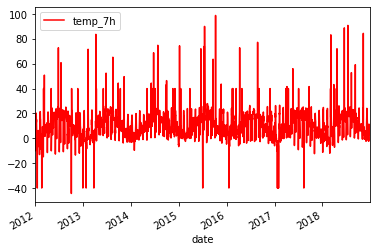

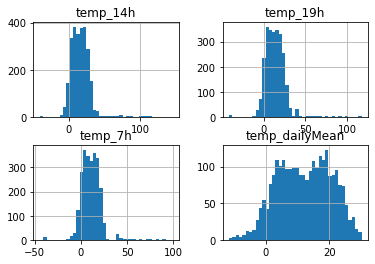

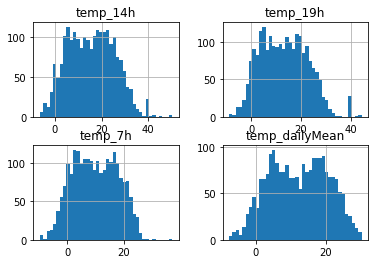

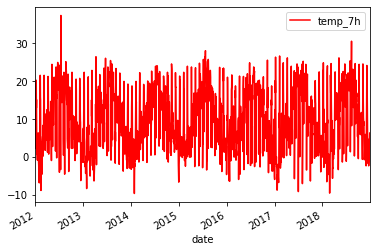

In [6]:
# from https://stackoverflow.com/a/56725366
def drop_numerical_outliers(df, z_thresh=2.5):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce=False) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)

def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    ### BEGIN SOLUTION
    noisy_data.plot(kind='line',x='date',y='temp_7h', color='red') # plot the data for temperature before handling outliers
    #logger.info(noisy_data)
    noisy_data[['temp_7h', 'temp_14h', 'temp_19h', 'temp_dailyMean']].hist(bins=40) # plot the temperature histogram before handling outliers
    
    drop_numerical_outliers(noisy_data) # handle the outliers by dropping them
    
    noisy_data[['temp_7h', 'temp_14h', 'temp_19h', 'temp_dailyMean']].hist(bins=40)# plot the temperature histogram after handling outliers
    cleaned_data = noisy_data # plot the data for temperature after handling outliers
    
    
    cleaned_data.plot(kind='line',x='date',y='temp_7h', color='red')
    
    #cleaned_data = noisy_data[(np.abs(stats.zscore(noisy_data)) < 3).all(axis=0)]
    
    ### END SOLUTION
    
    return cleaned_data
    
data_weather_cleaned = handle_outliers(data_weather_complete)


#### Your chosen strategy

In the cell below, explain your chosen strategy for dealing with outliers.


The function drop_numerical_outliers checks every point and compair it with the standart derivation of the data set. When the point is too far away it will be dropp them. We could also see the outliers in the histograms before the cleaning. 


## Task 4: Aggregate values
Total number of points for completing this task: **5**

Aggregate the observations on a weekly basis. Return a data frame with a hierarchical index (levels `year` and `week`) on the vertical axis and the following weekly aggregations as columns:

- `temp_weeklyMin`: minimum of `temp_dailyMin`
- `temp_weeklyMax`: mean of `temp_dailyMax`
- `temp_weeklyMean`: mean of `temp_dailyMean`
- `temp_7h_weeklyMedian`: median of `temp_7h`
- `temp_14h_weeklyMedian`: median of `temp_14h`
- `temp_19h_weeklyMedian`: median of `temp_19h`

- `hum_weeklyMean`: mean of `hum_dailyMean`
- `hum_7h_weeklyMedian`: median of `hum_7h`
- `hum_14h_weeklyMedian`: median of `hum_14h`
- `hum_19h_weeklyMedian`: median of `hum_19h`

- `precip_weeklyMean`: mean of `precip`
- `windBeauf_14h_weeklyMedian`: median of `windBeauf_14h`

In [7]:
def aggregate_weekly(data):
    """ 
    Parameters
    --------
    data: weather data frame
    
    Returns
    --------
    weekly_stats: data frame that contains statistics aggregated on a weekly basis
    """
    ### BEGIN SOLUTION
    #logger.info(data)
    stats = {}
    #
    stats['temp_weeklyMin'] = data.groupby(['year', 'week'])['temp_dailyMin'].min()
    stats['temp_weeklyMax'] = data.groupby(['year', 'week'])['temp_dailyMax'].max()
    stats['temp_weeklyMean'] = data.groupby(['year', 'week'])['temp_dailyMean'].mean()

    stats['temp_7h_weeklyMedian'] = data.groupby(['year', 'week'])['skyCover_7h'].median()
    stats['temp_14h_weeklyMedian'] = data.groupby(['year', 'week'])['skyCover_14h'].median()
    stats['temp_19h_weeklyMedian'] = data.groupby(['year', 'week'])['skyCover_19h'].median()
    #logger.info(stats)
    #stats['hum_weeklyMean'] = data.groupby(['year', 'week'])['hum_dailyMean'].mean()
    stats['hum_7h_weeklyMedian'] = data.groupby(['year', 'week'])['skyCover_7h'].median()
    stats['hum_14h_weeklyMedian'] = data.groupby(['year', 'week'])['skyCover_14h'].median()
    stats['hum_19h_weeklyMedian'] = data.groupby(['year', 'week'])['skyCover_19h'].median()
    stats['precip_mean'] = data.groupby(['year', 'week'])['precip'].mean()
    stats['windBeauf_14h_weeklyMedian'] = data.groupby(['year', 'week'])['windBeauf_14h'].mean()
    ### END SOLUTION
    
    weekly_weather_data = pd.DataFrame(stats)
    #logger.info(stats)
    return weekly_weather_data

data_weather_weekly = aggregate_weekly(data_weather_cleaned)

## Task 5: Merge influenza and weather datasets
Total number of points for completing this task: **5**

Merge the `data_weather_weekly` and `data_influenza` datasets.

In [8]:

def merge_data(weather_df, influenza_df):
    """ 
    Parameters
    --------
    weather_df: weekly weather data frame
    influenza_df: influenza data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both weekly weather observations and prevalence of influence infections
    """
    # explanation at https://stackoverflow.com/a/40468090
    ### BEGIN SOLUTION
    logger.debug(weather_df.dtypes)
    logger.debug(influenza_df.dtypes)
    merged_data = weather_df.merge(influenza_df,  how='left', on=['year','week']) # merge on the key, keep only the data if it is pressent in both data frames
    #merged_data = pd.concat([weather_df, influenza_df], axis=1)
    #merged_data = weather_df.merge(influenza_df, right_index=True, left_index=False) #.concat([weather_df, ], axis=1)
    logger.debug(merged_data)
    ### END SOLUTION

    return merged_data

data_merged = merge_data(data_weather_weekly, data_influenza)
data_merged_complete = data_merged.interpolate()
data_merged


temp_weeklyMin  temp_weeklyMax  temp_weeklyMean  \
year week                                                    
2012 1                1.6            34.9        18.016667   
     2                0.0            22.1         7.085714   
     3               -1.8             9.9         3.300000   
     4               -5.1             8.7         0.942857   
     5               -7.1            29.8         6.483333   
...                   ...             ...              ...   
2018 48              -5.2             5.8         1.366667   
     49               9.9            30.4        20.183333   
     50              -2.0            22.6         3.414286   
     51              -2.8             5.7         0.540000   
     52               1.4             9.3         5.320000   

           temp_7h_weeklyMedian  temp_14h_weeklyMedian  temp_19h_weeklyMedian  \
year week                                                                       
2012 1                      4.5                    6.0                    5.0   
     2                      8.0                    7.0                    9.0   
     3                     10.0                    8.0                    4.5   
     4                      3.0                    7.0                    7.0   
     5                      5.5                    5.5                    2.5   
...                         ...                    ...                    ...   
2018 48                     6.0                    9.5                    7.0   
     49                     4.0                    5.0                    5.5   
     50                    10.0                   10.0                   10.0   
     51                    10.0                   10.0                   10.0   
     52                     9.0                    7.0                    4.0   

           hum_7h_weeklyMedian  hum_14h_weeklyMedian  hum_19h_weeklyMedian  \
year week                                                                    
2012 1                     4.5                   6.0                   5.0   
     2                     8.0                   7.0                   9.0   
     3                    10.0                   8.0                   4.5   
     4                     3.0                   7.0                   7.0   
     5                     5.5                   5.5                   2.5   
...                        ...                   ...                   ...   
2018 48                    6.0                   9.5                   7.0   
     49                    4.0                   5.0                   5.5   
     50                   10.0                  10.0                  10.0   
     51                   10.0                  10.0                  10.0   
     52                    9.0                   7.0                   4.0   

           precip_mean  windBeauf_14h_weeklyMedian  weekly_infections  
year week                                                              
2012 1        0.100833                    2.333333             7300.0  
     2        1.316429                    2.857143             7500.0  
     3        1.950000                    4.000000             6900.0  
     4        1.472143                    3.142857             6900.0  
     5        0.483333                    2.833333             7900.0  
...                ...                         ...                ...  
2018 48       1.533333                    3.000000                NaN  
     49       2.083333                    3.000000                NaN  
     50       1.242857                    2.285714                NaN  
     51       0.241000                    1.800000             4900.0  
     52       2.980000                    3.400000                NaN  

[366 rows x 12 columns]

## Task 6: Visualization
Total number of points for completing this task: **15**

To get a better understanding of the dataset, create visualizations of the merged data set that help to explore the potential relationships between the variables before starting to develop a model.


**Note:** Hand in multiple figures, use a proper naming configuration for the image files.

INFO:__main__:Index(['temp_weeklyMin', 'temp_weeklyMax', 'temp_weeklyMean',
       'temp_7h_weeklyMedian', 'temp_14h_weeklyMedian',
       'temp_19h_weeklyMedian', 'hum_7h_weeklyMedian', 'hum_14h_weeklyMedian',
       'hum_19h_weeklyMedian', 'precip_mean', 'windBeauf_14h_weeklyMedian',
       'weekly_infections'],
      dtype='object')


Text(0, 0.5, 'number of rows')

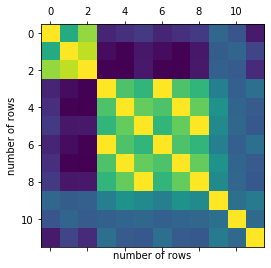

In [9]:

logger.info(data_merged.columns)
#logger.debug(data_merged.corr())

plt.matshow(data_merged.corr()) # show the correlation matri using the build in functions from pandas and matplot lib. The columns names are in the list. 
plt.xlabel("number of rows")
plt.ylabel("number of rows")

#data_merged.plot(kind='bar',x='temp_weeklyMin',y='temp_7h_weeklyMedian', color='red')

#plt.figure()
#data_merged[["temp_weeklyMin", "temp_7h_weeklyMedian"]].hist(bins=40)
#plt.xlabel("h = 1/resolution")
#plt.ylabel("error")

# fig.savefig(NAME + '_01.png', bbox_inches = 'tight')
# The graph shows the correlation of the rows from the data. The yellow fields mean that the correlation is zero. 
# The blue field # stands for a negative correlation. Conversely, the green field describes a positive correlation. 
#This graphic also shows a connection between the number of 'weelky_infections' and 'temp_7h_weeklyMedian'.

## Task 7: Influenza prediction model 
Total number of points for completing this task: **35**


Build a model to predict the number of influenza incidents for the first part of the 2018/2018 Influenza season (`influenza_predict.csv`) based on data of previous year using `sklearn`. 

 - Choose appropriate machine learning algorithm(s) for the problem at hand
 - Make sure your results are reproducible
 - Don't hesitate to go back to previous steps if you notice any data quality issues
 - If your chosen algorithm has specific parameters, explore their effect with different settings using 10-fold cross-validation
 - Experiment with different training/test splits
 - If appropriate, try different scaling approaches (min/max, z-score,..).
 - How good does your model fit when you evaluate it with the test data set?
 - How good are your predictions when you use the actual data available for 2018 as a validation set?
 

In [10]:
def load_influenza_data_predict():
    input_file = glob.glob('data/influenza/influenza_predict.csv')[0]
    data = pd.DataFrame()
    data = pd.read_csv(input_file,  sep = ',', header = 0)
    # print columns
    #print(data.columns)
    
    # split the week column (drop the .Woche part)
    data['week'], data['week_del'] = data['Kalenderwoche'].str.split('.', 1).str
    # print(data)
    # drop some columns
    
    cols_to_drop = ['ID', 'BEZEICHNUNG', 'Grippesaison ', 'Schwankungsbreite', 'week_del', 'Kalenderwoche']
    data = data.drop(cols_to_drop, axis = 1)
    
    data.rename(columns = {'Neuerkrankungen pro Woche': 'weekly_infections',
                           'Jahr' : 'year', 'Kalenderwoche' : 'week'}, inplace = True)
    data['weekly_infections'].replace("-",0, inplace=True)                             
    data['weekly_infections'] = pd.to_numeric(data['weekly_infections'])
    #data.set_index(['year', 'week'], inplace = True)
    #data.index.set_names(['year',  'week'], inplace = True)
    
    influenza_data_predict = data
    
    return influenza_data_predict


influenza_data_predict = load_influenza_data_predict()
#logger.info(data_infl)
influenza_data = data_infl.copy()
# try to catch only the data of the weeks 40-51
#logger.debug(influenza_data)
#wk = influenza_data.loc[('week_index', 40):('week_index', 51)]
#logger.debug(wk)
#influenza_data = influenza_data[wk]
logger.debug(influenza_data)

descriptors = influenza_data.copy()[["year", "week"]]
target = influenza_data[["weekly_infections"]].copy() # data to predict and compare

np.random.seed(seed=12345) # get allways the same random generator
msk = np.random.rand(len(descriptors)) <= 0.85 # mask to split the dataset into the training and test set
# for 10 fold cross validation we would need to make more splits like 0.95, 0.85, 0.75, ...
training_data = descriptors[msk]
test_data = descriptors[~msk]
training_target = target[msk]
test_target = target[~msk]

# Linear Regression
# I am using regression, because I have to predict a real number / integer which is not possible using the classification methods

reg = LinearRegression().fit(training_data, training_target) # learn how the data looks like
logger.debug(reg.score(training_data,training_target)) # predict and evaluate
reg.predict(test_data) # predict
logger.info(reg.score(test_data,test_target)) #evaluate

#Lasso Regression

#make parameters list
normalize = [False, True]
intercept = [True, False]
alpha = [1e-15, 1e-10, 1e-5, 1, 5, 10, 15]
results = [] # to collect the results

#loop through all possible parameter combinations
for n in normalize:
    for inter in intercept:
        for a in alpha:
            result_row = {}

            result_row["normalize"] = n
            result_row["intercept"] = inter
            result_row["alpha"] = a

            lasso = Lasso(alpha=a, fit_intercept=inter, normalize=n) # create the regressor

            lasso.fit(training_data, training_target)
            predicted = lasso.predict(test_data)

            result_row["score"] = round(lasso.score(test_data,test_target["weekly_infections"]), 4)
            results.append(result_row)
logger.info(pd.DataFrame(results)) # look over the result list to find the best parameters for machine learning


# Linear Regression revisited - as for the Lasso Regression
normalize = [False, True]
bias = [False, True]
interaction = [False, True]
intercept = [True, False]
degree = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ]
results = []
for n in normalize:
    for b in bias:
        for interact in interaction:
            for inter in intercept:
                for d in degree:

                    result_row = {}
                    result_row["normalize"] = n
                    result_row["bias"] = b
                    result_row["interaction"] = interact
                    result_row["intercept"] = inter
                    result_row["degree"] = d

                    poly = PolynomialFeatures(include_bias=b, interaction_only=interact, degree=d)
                    lrm = LinearRegression(normalize=n, fit_intercept=inter)
                    X_poly=poly.fit_transform(training_data)
                    X_p_poly=poly.fit_transform(test_data)
                    lrm.fit(X_poly, training_target)
                    result_row["score"] = round(lrm.score(X_p_poly,test_target["weekly_infections"]), 4)
                    results.append(result_row)
pd.set_option('display.max_rows', None)
logger.info(pd.DataFrame(results))
logger.info(pd.DataFrame(results)[["score"]].max())

# use the influenza predict to predict
test_descriptors = influenza_data_predict[["year", "week"]]
test_target = influenza_data_predict[["weekly_infections"]]*1000

poly = PolynomialFeatures(include_bias=True, interaction_only=False, degree=10)
lrm = LinearRegression(normalize=False, fit_intercept=True)
    
# use the full influenza to learn
X_poly=poly.fit_transform(descriptors)
X_p_poly=poly.fit_transform(test_descriptors)
#logger.info(test_descriptors)
#logger.info(descriptors)
lrm.fit(X_poly, target)
#logger.info(lrm.predict(X_p_poly))
#logger.info(round(lrm.score(X_p_poly,test_target["weekly_infections"]), 4)) # look how it performed

INFO:__main__:0.14852478817313985
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 978012761.9529319, tolerance: 237033.61421319802
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1030057040.4521487, tolerance: 1701451.0
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 974384191.9390687, tolerance: 1701451.0
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

INFO:__main__:score    0.6298
dtype: float64


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
influenza_data = data_infl.copy()
influenza_data

descriptors = influenza_data.copy()[["year", "week"]]
target = influenza_data[["weekly_infections"]].copy() # data to predict and compare
#descriptors
target
#influenza_data

,weekly_infections
0,6600
1,7100
2,7700
3,8300
4,8600
5,10800
6,14400
7,15800
8,16800
9,15300


#### Approach and algorithm
Motivate your approach and choice of algorithm in the cell below

#### Approach and algorithm
Motivate your approach and choice of algorithm in the cell below

First step was to load the test and result datas from the dictornary influenza.
Then I program a random number generator with a fixed seed 
After that I create a mask to split the data sets into training and test sets.
Then I great for lops for all possible parameter combinations
Check the result list for the best parameter for machine learning
and then I used a linear regression Lasso Regression

I noticed that this is a good way to predict the data. In the logger there is a score of 0.6298, which means that the prediction is 62% correct and overlaps with the combination of (72-74).

#### Findings 
Summarize your findings and lessens learned.

I compared my results with other colleagues and found that the results are different. There is no best way to program this prediction. There is always a better way to do this and convert to 1.